In [4]:
import pandas as pd
import itertools
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [30]:
data = pd.read_csv('circuit_flights_data.csv')
data['Date_time'] = pd.to_datetime(data['Date'])

In [31]:
data.columns

Index(['Unnamed: 0', 'FLIGHT_ID', 'Date', 'SCHEDULED_DEPARTURE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'Date_prev',
       'SCHEDULED_DEPARTURE_prev', 'ORIGIN_AIRPORT_prev',
       'DESTINATION_AIRPORT_prev', 'is_circuit', 'Date_time'],
      dtype='object')

# 寻找稳定circuit flight

稳定性：同日内航班线路恒定
近似判断方式：
1. 同日内航班次数恒定
2. 各目的地航班次数恒定

In [35]:
def check_soundness(data):
    flights = data['FLIGHT_ID'].unique()
    
    for flight in flights:
        _data = data.loc[data['FLIGHT_ID'] == flight]
        agg_airport = _data.groupby("DESTINATION_AIRPORT").size().reset_index().rename({0:'num'},axis=1)
        agg_date = _data.groupby("Date").size().reset_index().rename({0:'num'},axis=1)
        
        print(agg_airport)
        print(agg_date)
        
#check_soundness(data)

满足条件的航班号：
1. AS64（日5航班，1/1-12/31）
2. AS65 (日5航班，1/1-12/31)

# 2 ARIMA训练

In [5]:
data = pd.read_csv('dense_flights_data.csv')
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK',
       'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'ORIGIN_AIRPORT_IATA', 'DESTINATION_AIRPORT_IATA',
       'Date', 'SD', 'DT', 'WF', 'WN', 'SA', 'AT', 'FLIGHT_ID'],
      dtype='object')

In [8]:
def pipline(data,flight,is_iqr,is_boxcox):
    flights = data.loc[data['FLIGHT_ID'] == flight]
    y_raw = flights.iloc[:int(np.floor(flights.shape[0]*0.8)),:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')
    y_test = flights.iloc[int(np.floor(flights.shape[0]*0.8)):,:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')

    def IQR(y):
        Q3 = y.quantile(0.75)
        Q1 = y.quantile(0.25)
        IQR = Q3-Q1
        lower_bound = Q1 - IQR*1.5
        upper_bound = Q3 + IQR*1.5

        y[(y > upper_bound).values | (y<lower_bound).values] = np.nan
        y = y.interpolate(method='linear') 
        return y

    if is_iqr:
        y_iqr = IQR(y_raw)
    else:
        y_iqr = y_raw

    def box_cox(y):
        y_min = np.min(y)-0.1
        y_box, lbd = boxcox(y.values.ravel()-y_min)  
        return y_box,lbd,y_min

    if is_boxcox:
        y_box,lbd,y_min = box_cox(y_iqr)
    else:
        y_box = y_iqr

    y_box = pd.Series(y_box)

    model = pm.auto_arima(y_box, seasonal=True, trace=False)
    print(model.summary())

    y_pred = []
    for i in range(len(y_test)):
        forecast = model.predict_in_sample(X=y_box, start=len(y_box)-len(y_test)+i, end=len(y_box)-len(y_test)+i)
        y_pred.append(forecast.iloc[0])

    y_pred = np.array(y_pred)

    if is_boxcox:
        # 对预测值进行box-cox逆变换
        y_pred = inv_boxcox(y_pred, lbd) + y_min

    # 计算RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse:.3f}")

    # 计算MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {mae:.3f}")

    # 计算MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"MAPE: {mape:.3%}")

    # 创建时间索引
    time_index = range(len(y_box) - len(y_test), len(y_box))

    # 绘制实际值和预测值
    plt.figure(figsize=(12, 6))
    plt.plot(time_index, y_test.values, label='Actual')
    plt.plot(time_index, y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1452
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -2793.857
Date:                Tue, 07 May 2024   AIC                           5605.714
Time:                        15:13:44   BIC                           5653.240
Sample:                             0   HQIC                          5623.448
                               - 1452                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9501      3.948      1.000      0.317      -3.788      11.688
ar.L1         -0.2237      0.252     -0.887      0.375      -0.718       0.270
ar.L2          0.7464      0.259      2.878      0.0

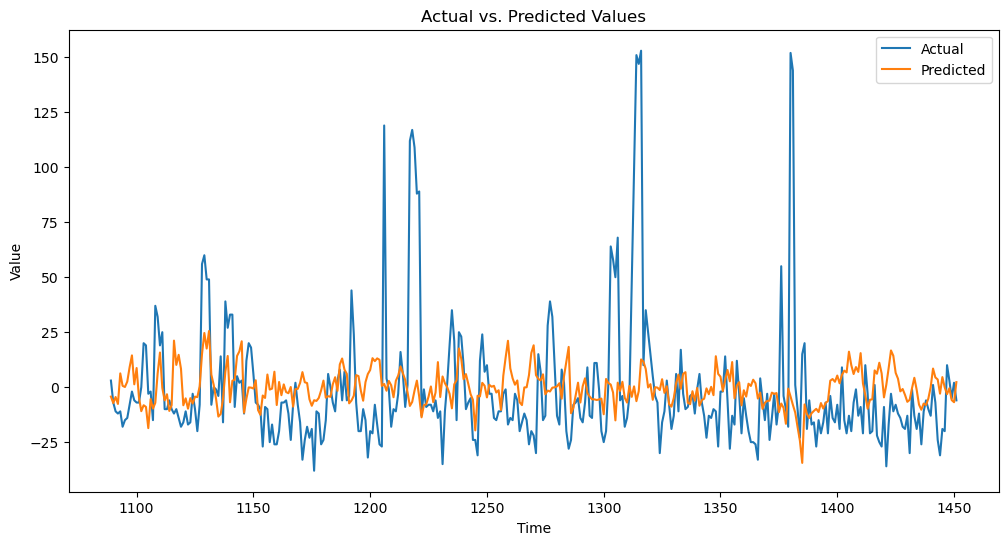

In [9]:
pipline(data,'AS64',True,True)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1451
Model:               SARIMAX(1, 1, 4)   Log Likelihood                -944.450
Date:                Tue, 07 May 2024   AIC                           1902.899
Time:                        15:16:34   BIC                           1939.855
Sample:                             0   HQIC                          1916.690
                               - 1451                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.026e-05      0.000      0.095      0.924      -0.001       0.001
ar.L1          0.0547      0.143      0.383      0.702      -0.225       0.334
ma.L1         -0.4848      0.142     -3.416      0.0

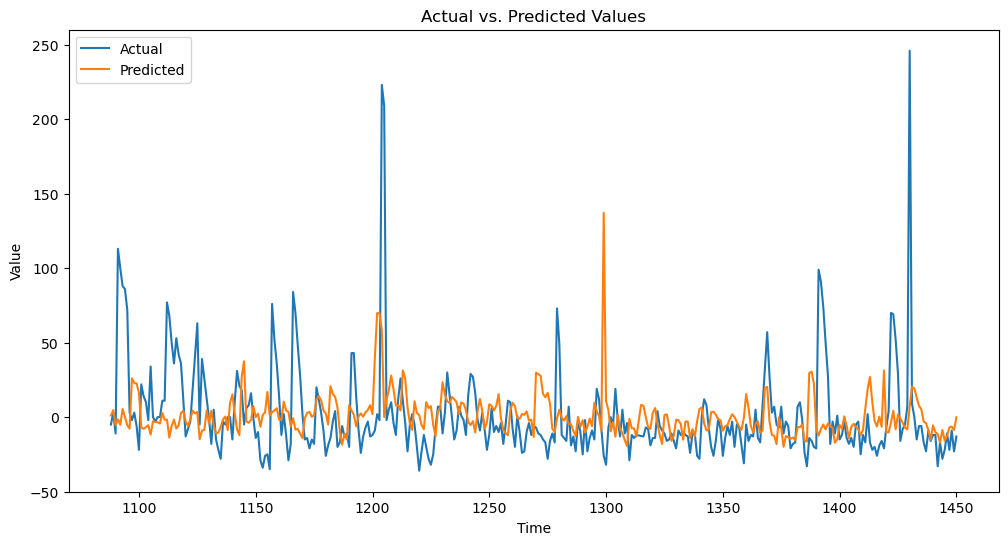

In [12]:
pipline(data,'AS65',False,True)

# 旧分析

In [89]:
flights = data.loc[data['FLIGHT_ID'] == 'AS64']#WN3771

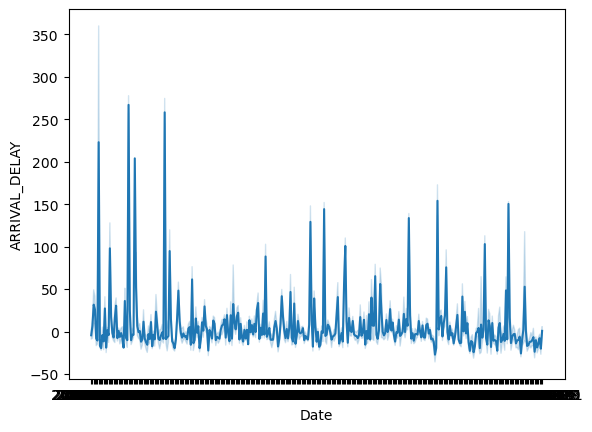

In [50]:
sns.lineplot(data=flights,x='Date',y='ARRIVAL_DELAY')
plt.show()

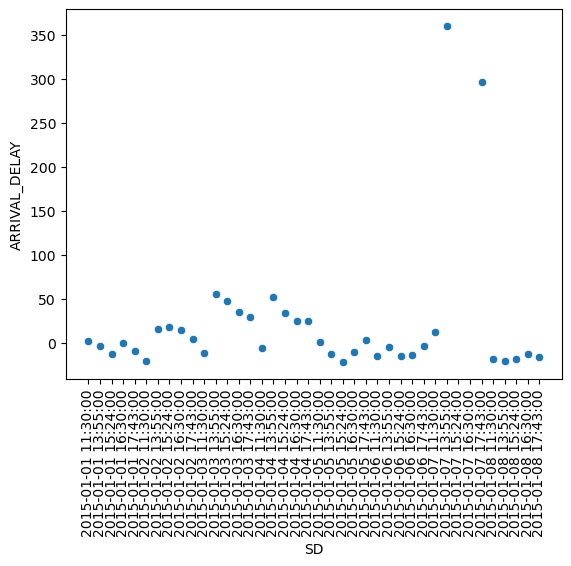

In [51]:
sns.scatterplot(data=flights.iloc[:40,:],x='SD',y='ARRIVAL_DELAY')
plt.xticks(rotation=90)
plt.show()

## 2-1 STL

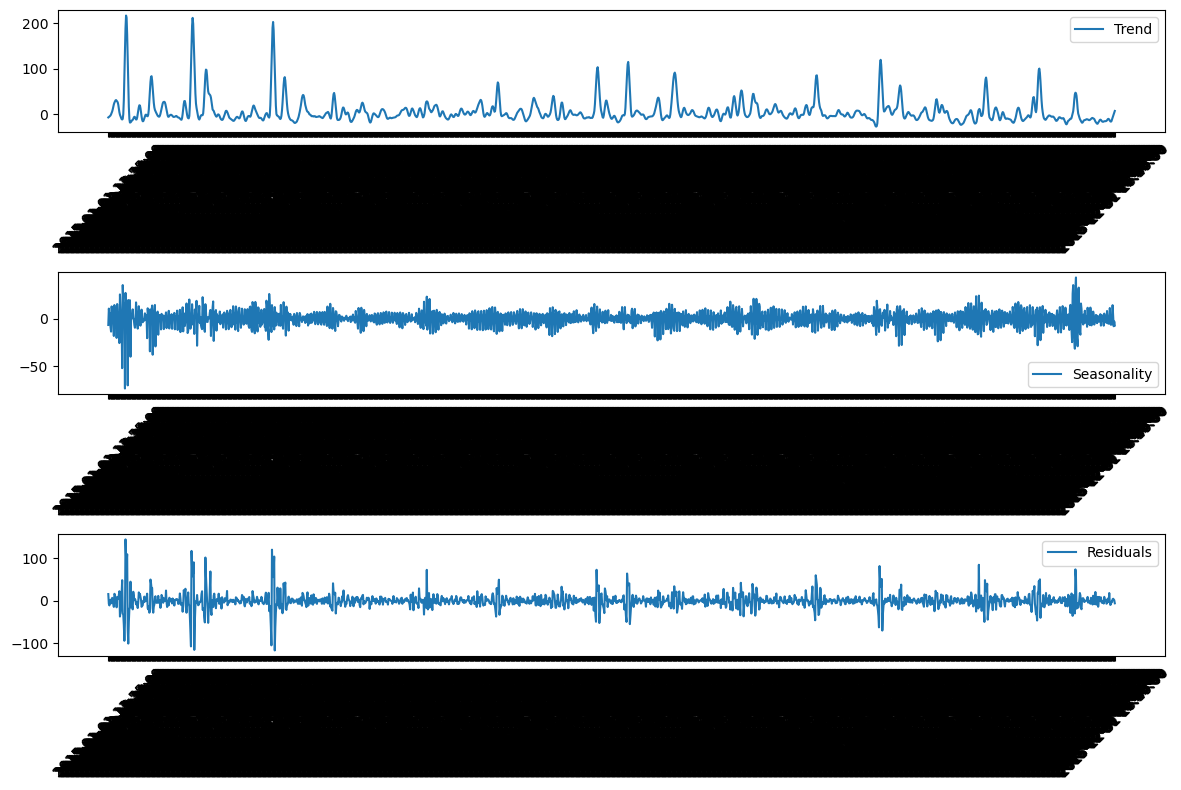

In [52]:
from statsmodels.tsa.seasonal import STL
stl = STL(flights['ARRIVAL_DELAY'].interpolate(method='linear'), period=5)
res = stl.fit()

season = res.seasonal
trend = res.trend
resid = res.resid

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
#plt.plot(flights.index, flights['ARRIVAL_DELAY'], label='Original')
plt.plot(flights['SD'], trend, label='Trend')
plt.xticks(rotation=45)
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(flights['SD'], season, label='Seasonality')
plt.xticks(rotation=45)
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(flights['SD'], resid, label='Residuals')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 2-2 训练测试集划分

In [115]:
y = flights.iloc[:int(np.floor(flights.shape[0]*0.8)),:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')
y_test = flights.iloc[int(np.floor(flights.shape[0]*0.8)):,:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')

## 2-3 IQR剔除异常值

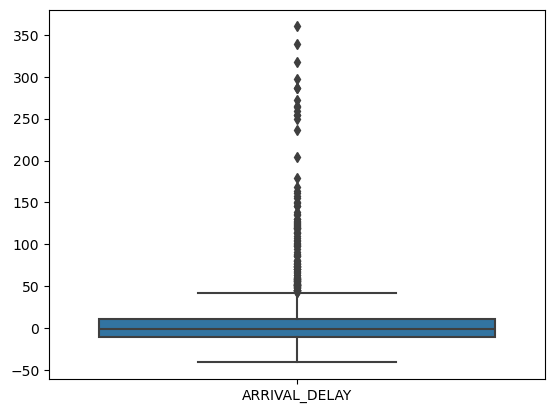

In [54]:
sns.boxplot(y)
plt.show()
Q3 = y.quantile(0.75)
Q1 = y.quantile(0.25)
IQR = Q3-Q1
lower_bound = Q1 - IQR*1.5
upper_bound = Q3 + IQR*1.5

y[(y > upper_bound).values | (y<lower_bound).values] = np.nan
y = y.interpolate(method='linear')

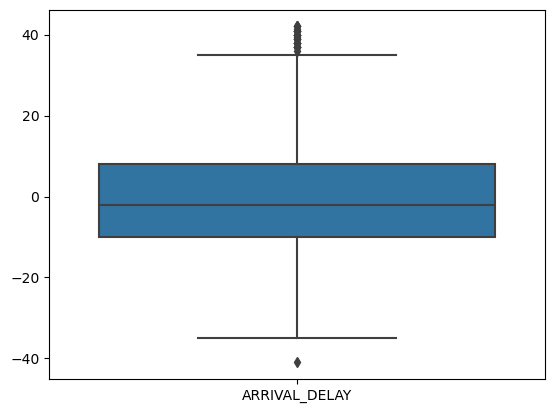

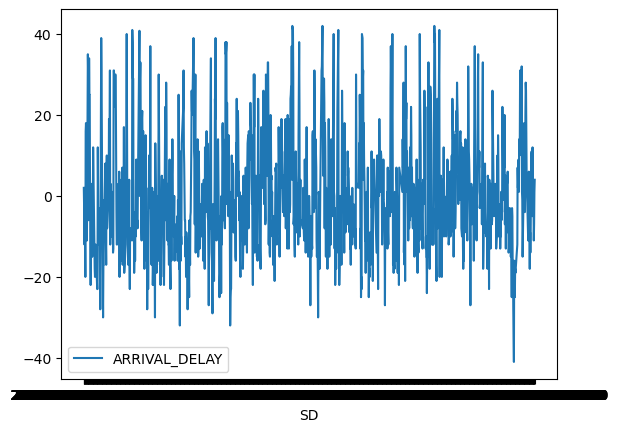

In [55]:
sns.boxplot(y)
plt.show()
sns.lineplot(y)
plt.show()

## 2-4 box-cox

In [56]:
# Box-Cox变换
y_min = np.min(y)-0.1
y_box, lmbda= boxcox(y.values.ravel()-y_min)  

## 2-5 ACF与PACF

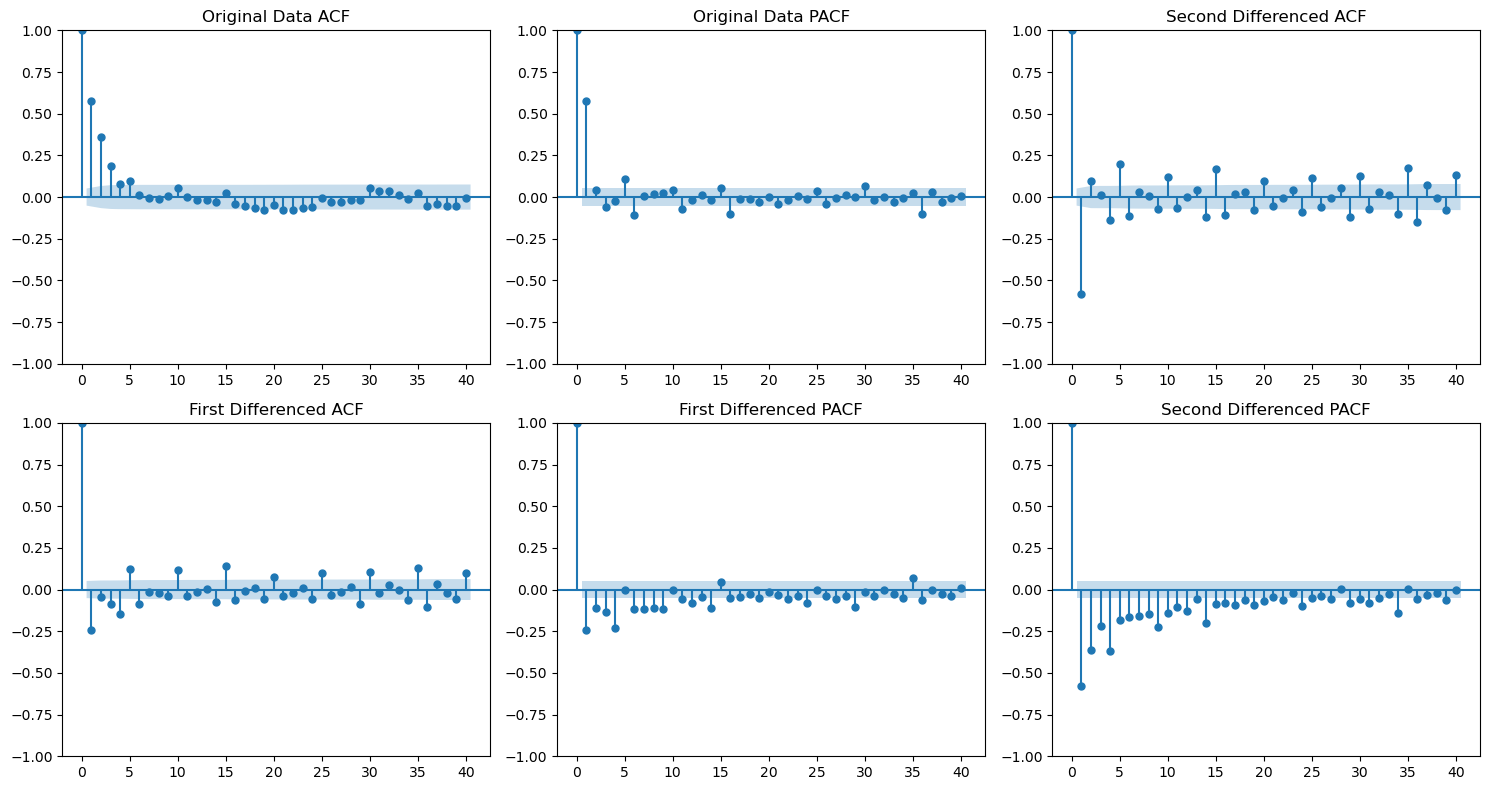

In [91]:
import statsmodels.graphics.tsaplots as tsa_plots
# 将NumPy数组转换为Pandas Series
y_box = pd.Series(y_box)

# 设置2行3列的子图布局
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# 原始数据
tsa_plots.plot_acf(y_box, lags=40, ax=axes[0, 0])
axes[0, 0].set_title('Original Data ACF')
tsa_plots.plot_pacf(y_box, lags=40, ax=axes[0, 1])
axes[0, 1].set_title('Original Data PACF')

# 一阶差分
y_diff1 = y_box.diff().dropna()
tsa_plots.plot_acf(y_diff1, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('First Differenced ACF')
tsa_plots.plot_pacf(y_diff1, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('First Differenced PACF')

# 二阶差分
y_diff2 = y_diff1.diff().dropna()
tsa_plots.plot_acf(y_diff2, lags=40, ax=axes[0, 2])
axes[0, 2].set_title('Second Differenced ACF')
tsa_plots.plot_pacf(y_diff2, lags=40, ax=axes[1, 2])
axes[1, 2].set_title('Second Differenced PACF')

# 调整子图布局
plt.tight_layout()
plt.show()

## 2-6 auto_arima

In [93]:
# 将NumPy数组转换为Pandas Series
y_box = pd.Series(y_box)

# 自动选择ARIMA模型参数
model = pm.auto_arima(y_box, seasonal=True, trace=False)

# 打印模型摘要
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1452
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -2793.857
Date:                Tue, 07 May 2024   AIC                           5605.714
Time:                        14:15:41   BIC                           5653.240
Sample:                             0   HQIC                          5623.448
                               - 1452                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9501      3.948      1.000      0.317      -3.788      11.688
ar.L1         -0.2237      0.252     -0.887      0.375      -0.718       0.270
ar.L2          0.7464      0.259      2.878      0.0

In [109]:
# 动态预测
y_pred = []
for i in range(len(y_test)):
    forecast = model.predict_in_sample(X=y_box, start=len(y_box)-len(y_test)+i, end=len(y_box)-len(y_test)+i)
    y_pred.append(forecast.iloc[0])

y_pred = np.array(y_pred)

# 计算偏差调整因子
#adjustment_factor = np.exp(np.sum(np.log(y - y_min)) / len(y))
#y_pred_adjusted = np.add(y_pred , adjustment_factor)

# 对预测值进行box-cox逆变换
y_pred = inv_boxcox(y_pred, lmbda) + y_min


In [110]:


# 计算RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.3f}")

# 计算MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.3f}")

# 计算MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.3%}")

RMSE: 30.175
MAE: 18.910
MAPE: 20282762885437932.000%


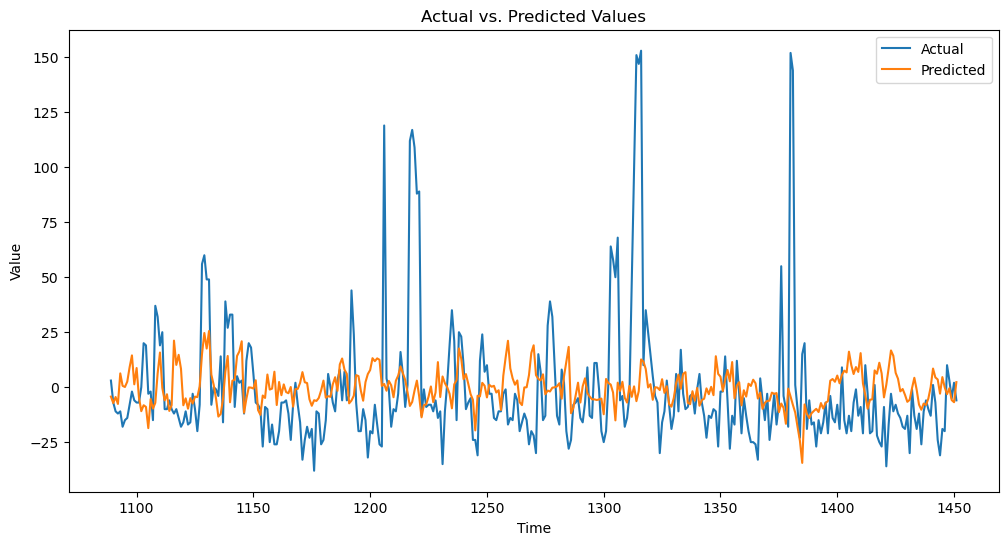

In [111]:
# 创建时间索引
time_index = range(len(y_box) - len(y_test), len(y_box))

# 绘制实际值和预测值
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test.values, label='Actual')
plt.plot(time_index, y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()